## 환경 설정

In [33]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [34]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("LOCA_Sprint2_Remake")

LangSmith 추적을 시작합니다.
[프로젝트명]
LOCA_Sprint2_Remake


In [35]:
## 데이터이쿠 모델을 가상으로 해둠.

from langchain_openai import ChatOpenAI
from langchain_teddynote.models import get_model_name, LLMs

MODEL_NAME = get_model_name(LLMs.GPT4o)

llm = ChatOpenAI(temperature=0, model=MODEL_NAME, streaming=True)

llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x0000024EF08BEE90>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000024EF62DD5D0>, root_client=<openai.OpenAI object at 0x0000024EF084DDD0>, root_async_client=<openai.AsyncOpenAI object at 0x0000024EF067BF90>, model_name='gpt-4o', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'), streaming=True)

# TESTING
# --------------------------------------------
# LOCA WORK FLOW

-----------------------
# 시작하기


In [36]:
# import sys
# sys.path.append("../")
from langchain_core.prompts import load_prompt
from _langchain_core import load_chat_prompt
from langgraph.graph import MessagesState
from langgraph.graph.message import AnyMessage
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from typing import List, Set, Annotated, Literal, Optional, Union
from langchain_core.documents import Document
from operator import add
from langchain_core.messages import RemoveMessage
from langchain_core.output_parsers import PydanticOutputParser, StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal, Annotated, Set, Tuple, Dict
from pydantic import BaseModel, Field
from langchain_core.messages import RemoveMessage
from langgraph.graph import START, END
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langchain_core.documents import Document

# 의도 분류 Output Classes

# VDB 정보 적기. 이름도 의미 담아서 적기 해당 부분을 나중에 파싱해서 VDB 정보 프롬프트를 구분할 것임.
# vdb_name = load_prompt("./Prompts/targets_name.yaml", encoding="utf-8").template.split() # 나중에 구조화를 통해 yaml관리


class IntentSelect(BaseModel):
    query: str = Field(..., description="사용자의 원본 질문 또는 재작성된 질문")

    target: Literal["FAQ", "VDB", "재질의"] = Field(
        ...,
        description=(
            "질문을 처리할 경로를 지정합니다.\n"
            "- 'FAQ': FAQ 검색 결과로 충분함\n"
            "- 'VDB': 특정 인덱스에서 추가 검색이 필요함\n"
            "- '재질의': 질의가 준법 가이드에 불적합하여 응답이 불가능하거나 VDB 분류하기 모호해서 사용자 재질의가 필요한 경우"
        ),
    )

    target_score: float = Field(
        ...,
        ge=0.0,
        le=1.0,
        description="해당 target 선택에 대한 신뢰도 점수 (0.0~1.0 사이)",
    )

    target_reason: str = Field(
        ..., description="왜 해당 target을 선택했는지 자연어로 설명"
    )

    requery_type: Optional[Literal["모호", "준법"]] = Field(
        default=None,
        description=(
            "target이 '재질의'일 경우, 그 사유를 지정합니다.\n"
            "- '모호': 질문이 어느 VDB를 검색할지 애매하거나 문맥이 부족함\n"
            "- '준법': 규정이나 정책 상 응답 불가"
        ),
    )
    vdb_index: Optional[List[Literal["Card", "Event", "Content"]]] = Field(
        default=None,
        description="target이 'VDB'일 경우, 검색 대상 인덱스 목록. 같은 인덱스 목록을 중복으로 넣지 마세요.",
    )


class SearchAttempt(BaseModel):
    origin_query: str
    query: str
    vdb_index: List[str]
    is_sufficient: Literal["충분", "부족"]
    reason: str


class QueryResult(BaseModel):
    original_query: str
    rewritten_queries: Optional[List[str]] = (
        None  # VDB만 채움 쿼리 변화를 추적하기 위함.
    )
    intent: Literal["FAQ", "VDB", "재질의"]  # FAQ, VDB, 재질의
    documents: List[Document] = Field(
        default_factory=list
    )  # 검색 결과 / 답변을 위해 쓰일 검색된 문서들
    answer: Optional[str] = (
        None  # 생성된 답변 / 만약 재질의라면 각 질문마다 답변을 생성하고 모아서 답변할것임.
    )
    final_vdb_index: Optional[List[str]] = None  # 마지막에 쓰인 VDB Index
    history: List[SearchAttempt] = []  # 히스토리 검색 기록 VDB만 있음

In [37]:
# llm.invoke([
#     {"role": "system", "content": "You are a helpful assistant."},
#     {"role": "user", "content": "안녕, 오늘 날씨 어때?"},
#     {"role": "assistant", "content": "오늘은 맑고 따뜻해요.", "tag" : "TEST"},
#     AIMessage(content='안녕하세요! 오늘 날씨는 지역에 따라 다를 수 있습니다. 특정 지역의 날씨를 알고 싶으시면, 지역 이름을 말씀해 주시면 더 정확한 정보를 드릴 수 있습니다. 일반적으로 날씨 앱이나 웹사이트를 통해 실시간 정보를 확인하시는 것도 좋은 방법입니다.', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'service_tier': 'default'}, id='run--15664a7c-db62-4623-a36d-fac3bfdf41b5-0'),
#     HumanMessage(content="그럼 날씨 말고 오늘 점심을 추천해줘")
# ])

In [38]:
class GraphState(MessagesState):
    # messages
    rewrited_query: str  # 요약된 최종 질문
    decomposited_query: List[str]  # 분해된 질문들

    intents: List[IntentSelect]  # 의도 분류 결과

    query_results: Annotated[
        List[QueryResult], add
    ]  # 각 분해된 질문들이 갖고온 문서 기록용

    latency_part_eval: Annotated[List[Tuple], add]  # 시간 측정용
    latency_TTFT_eval: Annotated[List[float], add]  # 시작, 종료, 걸린 시간
    latency_E2EL_eval: Annotated[List[float], add]  # 시작, 종료, 걸린 시간
    latency_ITL_eval: float  # 생성 걸린 시간

# 메세지 정리 노드

In [39]:
import time
import logging

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

In [40]:
def delete_messages(state: GraphState) -> GraphState:
    """
    주어진 state에서 오래된 메시지를 삭제합니다.
    """

    # state에서 메시지를 가져옵니다.
    start_time = time.time()

    messages = state["messages"]
    # 마지막 10 개의 메시지를 제외한 나머지 메시지를 삭제합니다.
    delete_messages = [RemoveMessage(id=message.id) for message in messages[:-10]]
    # 삭제된 메시지를 포함하는 새로운 state를 반환합니다.

    end_time = time.time()
    latency = end_time - start_time

    return {
        "messages": delete_messages,
        "latency_part_eval": [("[delete_messages]", latency)],
        "latency_TTFT_eval": [start_time],
        "latency_E2EL_eval": [start_time],
    }

# 사용자 질의 이해

In [41]:
# 사용자 질의 이해 Output Classes
class DecomposedQuery(BaseModel):
    decomposed_query: List[str] = Field(
        min_items=1,
        max_items=5,
        description="분해한 질문을 저장합니다. 무조건 최대 개수의 질문을 기록하지 않아도됩니다. 최대한 적은 수의 질문을 리턴해주세요.",
    )

In [42]:
# 사용자 질의 이해 클래스
class UnderstandingUserQueries:
    # 실질적 understandingUserQueries 호출
    def __call__(self, state: GraphState) -> GraphState:

        latency = []
        start_time = time.time()

        rewrited_query = self.query_rewrite(state["messages"])

        end_time = time.time()
        latency.append(
            ("[understandingUserQueries] query_rewrite", end_time - start_time)
        )

        start_time = time.time()

        decomposited_query = self.query_decomposition(rewrited_query).decomposed_query

        end_time = time.time()
        latency.append(
            ("[understandingUserQueries] query_decomposition", end_time - start_time)
        )

        return {
            "rewrited_query": rewrited_query,
            "decomposited_query": decomposited_query,
            "latency_part_eval": latency,
        }

    # 쿼리 재작성
    def query_rewrite(self, messages: List[AnyMessage]) -> str:

        query_rewrite_prompt = load_prompt(
            "Prompts/query_rewrite_prompt.yaml", encoding="utf-8"
        ).format(conversation=messages)

        query_chain = llm | StrOutputParser()
        query_rewrite_text = query_chain.invoke(query_rewrite_prompt)

        print(
            "*********************************** 쿼리 재작성 *****************************************"
        )
        print(query_rewrite_text)
        print()

        return query_rewrite_text

    # 쿼리 분해
    def query_decomposition(self, query: str) -> DecomposedQuery:
        decomposition_prompt = load_prompt(
            "Prompts/decomposition_prompt.yaml", encoding="utf-8"
        ).format(question=query)

        # 쿼리분해 프롬포트 템플릿
        structed_llm = llm.with_structured_output(DecomposedQuery)

        decomposed_query = structed_llm.invoke(decomposition_prompt)

        print(
            "*********************************** 쿼리 분해 *****************************************"
        )
        print(decomposed_query)
        print()

        return decomposed_query

### 테스트부분

In [43]:
# messages = [
#     HumanMessage(content="롯데카드 혜택을 알려주세요"),
#     AIMessage(content="어떤혜택을알려드릴까요?"),
#     HumanMessage(content="스타벅스 관련 혜택이요"),
# ]

# query_rewrite_prompt = load_prompt(
#     "Prompts/query_rewrite_prompt.yaml", encoding="utf-8"
# ).format(conversation=messages)

# query_chain = llm | StrOutputParser()
# query_rewrite_text = query_chain.invoke(query_rewrite_prompt)

# print(query_rewrite_text)

In [44]:
# decomposition_prompt = load_prompt("Prompts/decomposition_prompt.yaml", encoding="utf-8").format(question="스타벅스와 관련된 롯데카드 혜택은 무엇인가요?")

# # 쿼리분해 프롬포트 템플릿
# structed_llm = llm.with_structured_output(DecomposedQuery)

# decomposed_query = structed_llm.invoke(decomposition_prompt)
# decomposed_query

In [45]:
# understandingUserQueries().query_decomposition(
#     "카드 중에 카페나 공과금 할인되는거 있나요?"
# )

In [46]:
# understandingUserQueries()(
#     GraphState(
#         messages=[
#             HumanMessage(content="스타벅스 할인 카드가 있어?"),
#             AIMessage(content="아니요"),
#             HumanMessage(content="그럼 컨텐츠 없어?"),
#             AIMessage(content="컨텐츠는 존재합니다."),
#             HumanMessage(content="알려줄래?"),
#         ]
#     )
# )

In [47]:
# UnderstandingUserQueries()(GraphState(messages=[HumanMessage(content="아 덥다 더워")]))

# 의도 분류

In [48]:
# 의도분류 클래스
class IntentClassification:
    # 실질적 노드 콜링
    def __call__(self, state: GraphState) -> GraphState:
        latency = []
        intents: List[IntentSelect] = []

        for query in state["decomposited_query"]:
            start_time = time.time()

            # LLM을 통한 의도 분류
            intent = self.classify_intent(query)
            intents.append(intent)

            end_time = time.time()
            latency.append((f"[IntentClassification] {query}", end_time - start_time))
            print(
                "*********************************** 의도 분류 *****************************************"
            )
            print(query + " →")
            print()
            print(intent)
            print()

        return {
            "intents": intents,
            "latency_part_eval": latency,
        }

    def classify_intent(self, query: str) -> IntentSelect:
        faq = []  # FAQ 검색 결과 등을 넣을 수 있음
        compliance = []  # 준법 가이드 내용 등

        select_prompt = load_prompt(
            "Prompts/target_select_prompt.yaml", encoding="utf-8"
        ).format(question=query, faq=faq, compliance=compliance)

        structured_llm = llm.with_structured_output(IntentSelect)
        return structured_llm.invoke(select_prompt)

    @staticmethod
    def needs_requery(state: GraphState) -> bool:
        return any(intent.target == "재질의" for intent in state["intents"])

### 테스트 부분

In [49]:
# IntentClassification()(
#     {
#         "decomposited_query": [
#             "롯데 카드의 카드와 이벤트중에서 스타벅스 혜택 50%이상인 것을 알려주세요",
#             "롯데 캐피탈은 어느 영역의 서비스인가요?",
#         ]
#     }
# )

In [50]:
# IntentClassification().needs_requery(
#     IntentClassification()(
#     {
#         "decomposited_query": [
#             "롯데 카드의 카드와 이벤트중에서 스타벅스 혜택 50%이상인 것을 알려주세요",
#             "롯데 캐피탈은 어느 영역의 서비스인가요?",
#         ]
#     }
# ))

In [51]:
# IntentClassification()(
#     GraphState(
#         rewrited_query="스타벅스에서 사용할 수 있는 할인 카드나 할인 혜택이 있나요?",
#         decomposited_query=[
#             "스타벅스에서 사용할 수 있는 할인 카드는 무엇인가요?",
#             "스타벅스에서 받을 수 있는 할인 혜택은 어떤 것들이 있나요?",
#         ],
#     )
# )

# 재질의

In [52]:
class RequeryAnswerGenerator:
    # 재질의들 답변
    def __call__(self, state: GraphState) -> GraphState:

        results: List[QueryResult] = []
        latency: List[tuple] = []

        for intent in state["intents"]:
            if intent.target != "재질의":
                continue

            start_time = time.time()
            answer = self.generate_llm_answer(intent)
            end_time = time.time()

            latency.append(
                (f"[RequeryAnswerGenerator] {intent.query}", end_time - start_time)
            )

            result = QueryResult(
                original_query=intent.query,
                intent="재질의",
                documents=[],
                answer=answer,
            )
            results.append(result)
            print(
                "*********************************** 재질의 답변 *****************************************"
            )
            print()
            print(result)
            print()

        return {
            "query_results": results,
            "latency_part_eval": latency,
        }

    def generate_llm_answer(self, intent: IntentSelect) -> str:
        compliance = []  # 준법 가이드
        if intent.requery_type == "준법":
            prompt = load_prompt(
                "Prompts/requery_junbeop.yaml", encoding="utf-8"
            ).format(question=intent.query, compliance=compliance)
        elif intent.requery_type == "모호":
            prompt = load_prompt("Prompts/requery_moho.yaml", encoding="utf-8").format(
                question=intent.query
            )
        else:
            prompt = f"다음 질문은 답변이 어렵습니다. 질문을 명확히 해 주세요: {intent.query}"

        return llm.invoke(prompt).content

    # 재질의 모아서 최종 답변
    def RequeryAnswer(self, state: GraphState) -> GraphState:

        start_time = time.time()

        # 재질의 답변만 모음
        requery_answers = [
            result.answer
            for result in state["query_results"]
            if result.intent == "재질의" and result.answer
        ]

        # prompt 만들기
        prompt = self.build_aggregation_prompt(requery_answers)

        print(
            "*********************************** 재질의 답변 *****************************************"
        )
        print()
        print(prompt)
        print()

        chunks = []
        for i, chunk in enumerate(llm.stream(prompt)):
            if i == 0:
                start_token = time.time()

            try:
                chunks.append(f"{chunk.content}")
            except Exception as e:
                pass

        end_time = time.time()

        latency = [("[RequeryAnswer]", end_time - start_time)]

        TTFT = [start_token, (start_token - state["latency_TTFT_eval"][0])]
        E2EL = [end_time, (end_time - state["latency_E2EL_eval"][0])]

        return {
            "messages": AIMessage(content="".join(chunks)),
            "latency_part_eval": latency,
            "latency_TTFT_eval": TTFT,
            "latency_E2EL_eval": E2EL,
            "latency_ITL_eval": (end_time - start_time) / len(chunks),
        }

    def build_aggregation_prompt(self, answers: List[str]) -> str:
        if not answers:
            return "유효한 정보를 제공하지 못했습니다. 더 명확한 질문을 다시 입력해 달라는 안내를 해주세요."

        merged = "\n\n".join([f"{idx + 1}. {ans}" for idx, ans in enumerate(answers)])

        return load_prompt("Prompts/requery_answer.yaml", encoding="utf-8").format(
            merged=merged
        )

# FAQ

In [53]:
class FAQCollector:
    def __call__(self, state: GraphState) -> GraphState:
        latency = []
        results: List[QueryResult] = []

        for intent in state["intents"]:
            if intent.target != "FAQ":
                continue

            start_time = time.time()

            # 문서 검색 수행
            documents = self.search_faq_documents(intent.query)

            # 여기 부분에 추가 검색을 하여서 바꾸던가..

            # QueryResult 생성 (답변은 생성하지 않음)
            result = QueryResult(
                original_query=intent.query, intent="FAQ", documents=documents
            )
            results.append(result)

            end_time = time.time()
            latency.append((f"[FAQCollector] {intent.query}", end_time - start_time))

            print(
                "*********************************** FAQ 답변 *****************************************"
            )
            print()
            print(results)
            print()

        return {
            "query_results": results,
            "latency_part_eval": latency,
        }

    def search_faq_documents(self, query: str) -> List[Document]:
        return []
        return faq_retriever.similarity_search(query, k=3)

# VDB

In [ ]:
from typing import List, Dict, Literal, Optional, Any
from pydantic import BaseModel, Field, create_model
import time


class VDBEntity(BaseModel):
    Card_entity: Optional[List[str]] = Field(None, description="Card 관련 entity")
    Event_entity: Optional[List[str]] = Field(None, description="Event 관련 entity")
    Content_entity: Optional[List[str]] = Field(
        None, description="Coontent 관련 entity"
    )


class SufficiencyCheck(BaseModel):
    is_sufficient: Literal["충분", "부족"] = Field(
        ..., description="문서가 질문에 대해 충분히 답변 가능한지 여부"
    )
    reason: str = Field(..., description="그 판단의 이유 (1~2문장 요약)")


class ReconsiderResult(BaseModel):
    query: str = Field(
        ..., description="과거 검색 이력을 기반으로 재작성된 최적의 검색 질문입니다."
    )
    vdb_index: List[Literal["Card", "Event", "Content"]] = Field(
        ..., description="재작성된 질문에 대해 검색해야 할 VDB 인덱스 목록입니다."
    )

In [ ]:
class VDBSupervisor:
    def __call__(self, state: GraphState) -> GraphState:
        latency_all = []
        results: List[QueryResult] = []

        for intent in state["intents"]:
            if intent.target != "VDB":
                continue

            print(
                "*********************************** VDB 답변 *****************************************"
            )
            print()
            print(intent)
            print()

            original_query = intent.query
            current_query = original_query
            current_indexes = intent.vdb_index
            rewritten_queries = [original_query]
            search_history = []  # List[SearchAttempt]
            retries = 0
            max_retries = 3
            success = False

            while retries < max_retries:
                start_time = time.time()

                # 1. 엔티티 추출
                entities = self.extract_entities(current_query, current_indexes)

                end_time = time.time()
                latency_all.append(
                    (
                        f"[VDBProcessor][{original_query}] extract_entities count : {retries}",
                        end_time - start_time,
                    )
                )

                if not self.validate_entities(entities, current_indexes):
                    results.append(
                        QueryResult(
                            original_query=original_query,
                            rewritten_queries=rewritten_queries,
                            intent="재질의",
                            documents=[],
                            answer="필수 정보가 누락되어 재질의가 필요합니다.",
                            history=search_history,
                        )
                    )
                    break

                start_time = time.time()

                # 2. 쿼리 재작성
                rewritten_query = self.rewrite_query(current_query, entities)
                rewritten_queries.append(rewritten_query)

                end_time = time.time()
                latency_all.append(
                    (
                        f"[VDBProcessor][{original_query}] rewrite_query count : {retries}",
                        end_time - start_time,
                    )
                )

                # 3. 문서 검색
                docs = self.search_vdb_documents(rewritten_query, current_indexes)

                start_time = time.time()

                # 4. 문서 적합성 판단
                sufficiency = self.check_document_sufficiency(docs, rewritten_query)
                search_history.append(
                    SearchAttempt(
                        query=rewritten_query,
                        vdb_index=current_indexes,
                        is_sufficient=sufficiency.is_sufficient,
                        reason=sufficiency.reason,
                    )
                )

                end_time = time.time()
                latency_all.append(
                    (
                        f"[VDBProcessor][{original_query}] check_document_sufficiency count : {retries}",
                        end_time - start_time,
                    )
                )

                if sufficiency.is_sufficient == "충분":
                    results.append(
                        QueryResult(
                            original_query=original_query,
                            rewritten_queries=rewritten_queries,
                            intent="VDB",
                            documents=docs,
                            final_vdb_index=current_indexes,
                            history=search_history,
                        )
                    )
                    success = True
                    break

                start_time = time.time()

                # 5. 재판단
                reconsidered = self.reconsider_index_and_query(search_history)
                current_query = reconsidered.query
                current_indexes = reconsidered.vdb_index

                end_time = time.time()
                latency_all.append(
                    (
                        f"[VDBProcessor][{original_query}] reconsider_index_and_query count : {retries}",
                        end_time - start_time,
                    )
                )

                retries += 1

            if not success:
                results.append(
                    QueryResult(
                        original_query=original_query,
                        rewritten_queries=rewritten_queries,
                        intent="재질의",
                        documents=[],
                        answer="해당 질문에 명확히 답변할 수 있는 문서를 찾을 수 없습니다. 보다 구체적인 질문을 남겨주세요.",
                        history=search_history,
                    )
                )

            print(
                f"*********************************** {original_query} 히스토리 *****************************************"
            )
            print("답변의 변화 과정")
            print(f"{rewritten_queries}")
            print()
            print(search_history)
            print()

        return {"query_results": results, "latency_part_eval": latency_all}

    def extract_entities(self, query: str, indexes: List[str]) -> VDBEntity:
        prompt_template = load_prompt(
            "Prompts/extract_entities_prompt.yaml", encoding="utf-8"
        )
        prompt = prompt_template.format(query=query, vdb_index=", ".join(indexes))
        parser = llm.with_structured_output(VDBEntity)
        return parser.invoke(prompt)

    def validate_entities(self, entities: VDBEntity, current_indexes) -> bool:
        # 필수 엔티티 현재 : 카드명 또는 이벤트명 중 하나는 있어야 함. 해당 로직은 변경되어야 할 것. 어떤 인덱스냐에따라...
        check = True
        for i in current_indexes:
            if i == "Card":
                check = check and entities.Card_entity
            elif i == "Event":
                check = check and entities.Event_entity
            elif i == "Content":
                check = check and entities.Content_entity
        return True  # 기준 명확...X

    def rewrite_query(self, original: str, entities: VDBEntity) -> str:
        prompt_template = load_prompt(
            "Prompts/rewrite_query_prompt.yaml", encoding="utf-8"
        )
        prompt = prompt_template.format(
            original=original,
            Card=entities.Card_entity or "없음",
            Event=entities.Event_entity or "없음",
            Content=entities.Content_entity or "없음",
        )
        return llm.invoke(prompt).content

    def search_vdb_documents(self, query: str, indexes: List[str]) -> List[Document]:
        # 인덱스별 벡터 검색
        # self.... 을 통해 갖고있게 할까 생각중
        # 인덱스별 하이브리드 서치 갖고오기? 몇개? Dense는? Sparse는?
        # 현재 하이브리드 서치 3개씩 가져옴

        total = []

        for i in indexes:
            if i == "Card":
                total += []
            elif i == "Event":
                total += []
            elif i == "Content":
                total += []

        return total

    def check_document_sufficiency(
        self, docs: List[Document], query: str
    ) -> SufficiencyCheck:
        if not docs:
            return SufficiencyCheck(is_sufficient="부족", reason="문서가 없습니다.")

        # top_k = docs[:3]  # 상위 3개 문서만 판단에 사용? 여기에 로직 들가도록 ( 리랭킹 구조 확장 고려 )
        # context = "\n\n".join([doc.page_content for doc in top_k])
        context = "\n\n".join(
            [doc.page_content for doc in docs]
        )  # 해당 부분 <> 태그로 감쌀것인지 고려 필요 ( 성능 )

        prompt_template = load_prompt(
            "Prompts/check_sufficiency_prompt.yaml", encoding="utf-8"
        )
        prompt = prompt_template.format(query=query, documents=context)
        parser = llm.with_structured_output(SufficiencyCheck)
        return parser.invoke(prompt)

    def reconsider_index_and_query(
        self, history: List[SearchAttempt]
    ) -> ReconsiderResult:
        history_str = "\n\n".join(
            [
                f"[{i+1}회차 검색]\n- 검색 질문: {h.query}\n- 인덱스: {', '.join(h.vdb_index)}\n- 적합성: {h.is_sufficient}\n- 이유: {h.reason}"
                for i, h in enumerate(history)
            ]
        )
        prompt_template = load_prompt(
            "Prompts/reconsider_query_and_index.yaml", encoding="utf-8"
        )
        prompt = prompt_template.format(history=history_str)
        parser = llm.with_structured_output(ReconsiderResult)
        return parser.invoke(prompt)

In [56]:
# from typing import List

# intents: List[IntentSelect] = [
#     # 예시 1: VDB 처리 대상 (카드 인덱스)
#     IntentSelect(
#         query="하나 카드의 적립 한도는 어떻게 되나요?",
#         target="VDB",
#         target_score=0.92,
#         target_reason="질문이 특정 카드 상품의 혜택에 대해 묻고 있으므로 카드 인덱스 검색이 필요합니다.",
#         vdb_index=["카드"],
#     ),
#     # 예시 2: 재질의 (모호함)
#     IntentSelect(
#         query="이벤트 언제 시작해요?",
#         target="재질의",
#         target_score=0.67,
#         target_reason="질문에 이벤트명이 명시되어 있지 않아 검색이 불가능하며, 모호합니다.",
#         requery_type="모호",
#     ),
#     # 예시 3: VDB 처리 대상이지만 컨텐츠 인덱스 필요 (초기에 카드로 잘못 판단되었다고 가정)
#     IntentSelect(
#         query="프리미엄 카드로 스트리밍 컨텐츠 받을 수 있나요?",
#         target="VDB",
#         target_score=0.78,
#         target_reason="카드와 관련된 컨텐츠 혜택을 확인하려는 질문으로 보이며, 카드 또는 컨텐츠 인덱스 탐색이 필요합니다.",
#         vdb_index=["카드"],  # 초기 판단은 카드, 이후 바뀔 수도 있음
#     ),
#     # 예시 4: FAQ로 충분한 케이스
#     IntentSelect(
#         query="연회비는 얼마인가요?",
#         target="FAQ",
#         target_score=0.95,
#         target_reason="자주 묻는 질문에 해당하며, FAQ에서 바로 답변이 가능합니다.",
#     ),
#     # 예시 5: 재질의 (준법 불가)
#     IntentSelect(
#         query="카드 승인 제한 기준은 어떻게 돼?",
#         target="재질의",
#         target_score=0.88,
#         target_reason="카드 심사 기준 관련 질의는 규정상 제공 불가하여 응답할 수 없습니다.",
#         requery_type="준법",
#     ),
# ]


# supervisor = VDBSupervisor()

# state = {"intents": intents}

# result_state = supervisor(state)

# Answer 생성

In [ ]:
class AnswerGenerator:
    def __call__(self, state: GraphState) -> GraphState:
        query_results: List[QueryResult] = state["query_results"]

        if any(q.intent == "재질의" for q in query_results):
            # 1. 재질의가 포함된 경우
            return self.handle_requery(state, query_results)
        else:
            # 2. 모두 FAQ/ VDB 인 경우
            return self.handle_faq_and_vdb(state, query_results)

    def handle_requery(self, state, results: List[QueryResult]) -> str:
        # intent가 재질의 인것만 모음
        requery_results = [r for r in results if r.intent == "재질의"]

        # 각 answer를 취합
        aggregated_feedback = "\n\n".join(
            f"- 질문: {r.original_query}\n  안내: {r.answer or '추가 정보가 필요합니다.'}"
            for r in requery_results
        )

        prompt = (
            "다음은 사용자의 질문들 중 답변이 어려웠던 항목들입니다. "
            "각 항목에 대해 사용자에게 어떤 추가 정보를 요청해야 하는지 명확히 정리해주세요.\n\n"
            f"{aggregated_feedback}"
        )

        print(
            "*********************************** FAQ, VDB 합치기 ( 재질의 존재 ) *****************************************"
        )
        print(prompt)

        start_time = time.time()

        chunks = []
        for i, chunk in enumerate(llm.stream(prompt)):
            if i == 0:
                start_token = time.time()

            try:
                chunks.append(f"{chunk.content}")
            except Exception as e:
                pass

        end_time = time.time()

        latency = [("[AnswerGenerator] [handle_requery]", end_time - start_time)]

        TTFT = [start_token, (start_token - state["latency_TTFT_eval"][0])]
        E2EL = [end_time, (end_time - state["latency_E2EL_eval"][0])]

        return {
            "messages": AIMessage(content="".join(chunks)),
            "latency_part_eval": latency,
            "latency_TTFT_eval": TTFT,
            "latency_E2EL_eval": E2EL,
            "latency_ITL_eval": (end_time - start_time) / len(chunks),
        }

    def handle_faq_and_vdb(self, state, results: List[QueryResult]) -> str:
        context_blocks = []

        for r in results:
            doc_blocks = []

            for doc in r.documents[:3]:  # 상위 3개 문서
                if r.intent == "FAQ":
                    answer = doc.metadata.get("answer", "")
                    doc_blocks.append(f"Q: {doc.page_content}\nA: {answer}")
                elif r.intent == "VDB":
                    doc_blocks.append(doc.page_content)

            docs_text = "\n\n".join(doc_blocks)

            context_blocks.append(
                f"[질문]\n{r.original_query}\n\n[문서 발췌]\n{docs_text}"
            )

        all_context = "\n\n---\n\n".join(context_blocks)

        # 답변 템플릿 지정해야함.
        prompt = (
            "다음은 사용자의 여러 질문과 각 질문에 대해 검색된 문서들입니다. "
            "각 질문에 대해 적절한 정보를 종합하여 하나의 응집력 있는 답변을 생성해주세요. "
            "답변은 문서 근거를 바탕으로 자연스럽게 구성하되, 질문 별로 구분 없이 연속된 흐름으로 작성해주세요.\n\n"
            f"{all_context}"
        )

        print(
            "*********************************** FAQ, VDB 합치기 *****************************************"
        )
        print(prompt)

        start_time = time.time()

        chunks = []
        for i, chunk in enumerate(llm.stream(prompt)):
            if i == 0:
                start_token = time.time()

            try:
                chunks.append(f"{chunk.content}")
            except Exception as e:
                pass

        end_time = time.time()

        latency = [("[AnswerGenerator] [handle_requery]", end_time - start_time)]

        TTFT = [start_token, (start_token - state["latency_TTFT_eval"][0])]
        E2EL = [end_time, (end_time - state["latency_E2EL_eval"][0])]

        return {
            "messages": AIMessage(content="".join(chunks)),
            "latency_part_eval": latency,
            "latency_TTFT_eval": TTFT,
            "latency_E2EL_eval": E2EL,
            "latency_ITL_eval": (end_time - start_time) / len(chunks),
        }

# 컴파일

In [58]:
graph_builder = StateGraph(GraphState)

graph_builder.add_edge(START, "delete_messages")

graph_builder.add_node("delete_messages", delete_messages)

graph_builder.add_edge("delete_messages", "UnderstandingUserQueries")

graph_builder.add_node("UnderstandingUserQueries", UnderstandingUserQueries())

graph_builder.add_edge("UnderstandingUserQueries", "IntentClassification")

graph_builder.add_node("IntentClassification", IntentClassification())

graph_builder.add_conditional_edges(
    "IntentClassification",
    IntentClassification.needs_requery,
    {
        True: "RequeryAnswerGenerator",
        False: "answering_node",
    },
)

# 재질의

graph_builder.add_node("RequeryAnswerGenerator", RequeryAnswerGenerator())

graph_builder.add_edge("RequeryAnswerGenerator", "RequeryAnswer")

graph_builder.add_node("RequeryAnswer", RequeryAnswerGenerator().RequeryAnswer)

graph_builder.add_edge("RequeryAnswer", END)

# FAQ, VDB

graph_builder.add_node("answering_node", lambda x: x)

graph_builder.add_edge("answering_node", "FAQCollector")
graph_builder.add_edge("answering_node", "VDBSupervisor")

graph_builder.add_node("FAQCollector", FAQCollector())
graph_builder.add_node("VDBSupervisor", VDBSupervisor())

graph_builder.add_edge("FAQCollector", "AnswerGenerator")
graph_builder.add_edge("VDBSupervisor", "AnswerGenerator")

graph_builder.add_node("AnswerGenerator", AnswerGenerator())

graph_builder.add_edge("AnswerGenerator", END)


graph = graph_builder.compile()

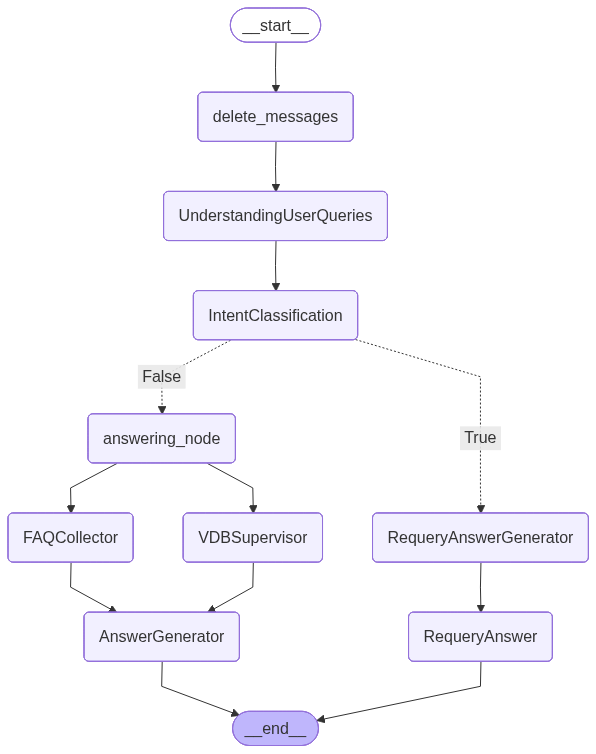

In [59]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [60]:
# graph.invoke(
#     GraphState(
#         messages=[
#             HumanMessage(content="나는 재질의를 할거야!"),
#         ]
#     )
# )

In [61]:
# graph.invoke(
#     GraphState(
#         messages=[
#             HumanMessage(content="스타벅스 컨텐츠가 있어?"),
#             AIMessage(content="아니요"),
#             HumanMessage(content="그럼 카드는 없어?"),
#             AIMessage(content="카드는 존재합니다."),
#             HumanMessage(content="알려줄래?"),
#         ]
#     )
# )